# Statistical Analysis of the Wisconsin Breast Cancer Dataset

The Wisconsin Breast Cancer Dataset contains samples with potential Breast Cancer [from the following study](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.56.707&rep=rep1&type=pdf). According to documentaion,  

"Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image."

Goals of Analysis:
1. Clean and explore the breast cancer cata
2. Classify whether a sample has breast cancer or not based on its attributes

For item 2, we plan to make a model that takes in a Sample ID corresponding to several ranked attributes and classifies the sample as benign or malignant. Therefore the input features will be the 9 descriptive characteristics and the output variable will be the class AKA the presence or absence of Breast Cancer.


[FEATURES ADD]
- precision recall
- ROC curve
- Find model errors
---------------------------------------------------------------------
- Imputer
- Grid Search?
- Ensemble?


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

## Importing the Data

In [16]:
names = ['ID', 'ClumpThickness', 'UniformCellSize', 'UniformCellShape', 'MarginalAdhesion', 
         'SingleEpiSize', 'BareNuclei', 'BlandChromatin', 'NormalNucleoli', 'Mitoses', 'Class']
df = pd.read_csv('breast-cancer-wisconsin.data', names=names, index_col=0, na_values='?')
df.head()

,ClumpThickness,UniformCellSize,UniformCellShape,MarginalAdhesion,SingleEpiSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
ID,,,,,,,,,,
1000025,5,1,1,1,2,1.0,3,1,1,2
1002945,5,4,4,5,7,10.0,3,2,1,2
1015425,3,1,1,1,2,2.0,3,1,1,2
1016277,6,8,8,1,3,4.0,3,7,1,2
1017023,4,1,1,3,2,1.0,3,1,1,2


## Missing Values

In [4]:
df.count()

ClumpThickness      699
UniformCellSize     699
UniformCellShape    699
MarginalAdhesion    699
SingleEpiSize       699
BareNuclei          683
BlandChromatin      699
NormalNucleoli      699
Mitoses             699
Class               699
dtype: int64

The documentation states that there are 16 NaN values. `df.count()` shows these values are all in the "Bare Nuclei" attribute. We use a mean imputer to fill these values because the data has no outliers.

In [5]:
def mean_imputer(dataframe, column):
# takes dataframe and column indexed from dataframe and replaces missing values with mean of present values
    mean = np.mean(column)
    column = column.fillna(mean, inplace=True)

mean_imputer(df, df['BareNuclei'])

df.count()

ClumpThickness      699
UniformCellSize     699
UniformCellShape    699
MarginalAdhesion    699
SingleEpiSize       699
BareNuclei          699
BlandChromatin      699
NormalNucleoli      699
Mitoses             699
Class               699
dtype: int64

## Features

According to the attached documentation, `breast-cancer-wisconsin.names`, there are 11 features. 9 of these attributes are rated on a scale 1-10 describing qualities of a sample. The Class attribute contains the breast cancer diagnosis for a sample.

   1. Sample code number            id number Nominal
   2. Clump Thickness               1 - 10    Ordinal
   3. Uniformity of Cell Size       1 - 10    Ordinal
   4. Uniformity of Cell Shape      1 - 10    Ordinal
   5. Marginal Adhesion             1 - 10    Ordinal
   6. Single Epithelial Cell Size   1 - 10    Ordinal
   7. Bare Nuclei                   1 - 10    Ordinal
   8. Bland Chromatin               1 - 10    Ordinal
   9. Normal Nucleoli               1 - 10    Ordinal
   10. Mitoses                      1 - 10    Ordinal
   11. Class:                        (2 for benign, 4 for malignant) Nominal
   
The sample code number has a nominal data type because each ID number is unique and has no order, at least in the context of our problem. The 9 descriptive attributes are ordinal data type because they have discrete integer values 1-10 however these values have order relative to eachother. The class attribute is nominal because there are two distinct categories with no ordered relation.

Because the input variables are ordered but the output variable is categorical, we use a classification model to accomplish our task.

All 9 input variables use the same rating scale, therefore feature scaling will not be necessary.

In [6]:
df.describe()

,ClumpThickness,UniformCellSize,UniformCellShape,MarginalAdhesion,SingleEpiSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.601852,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [7]:
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BC64B61C50>,
      dtype=object)

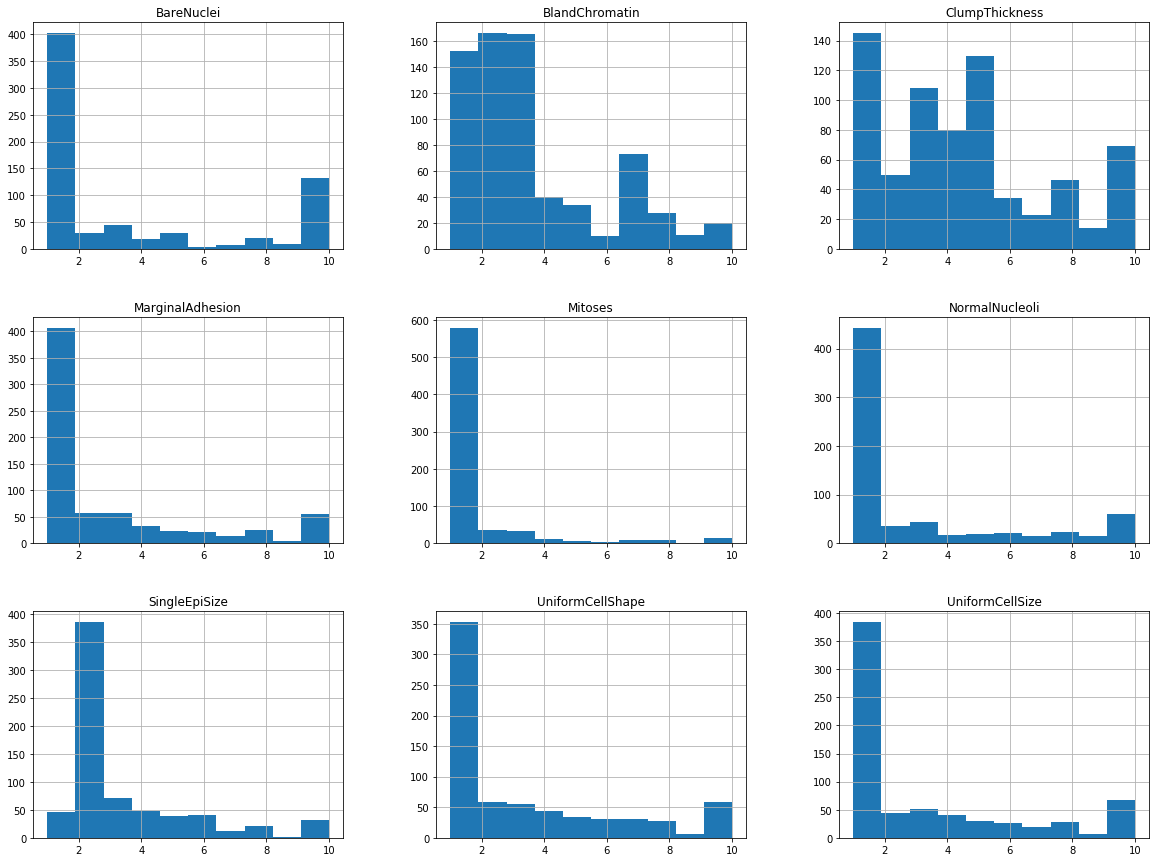

In [8]:
attributes = ['ClumpThickness', 'UniformCellSize', 'UniformCellShape', 'MarginalAdhesion', 
         'SingleEpiSize', 'BareNuclei', 'BlandChromatin', 'NormalNucleoli', 'Mitoses']
df[attributes].hist(figsize=(20,15))

Generally the 9 qualitative attributes are right skew with the majority of the distribution spread between ratings 1-3. The exceptions are Bland Chromatin and Clump Thickness, where the distribution is still skewed right but closer to the middle. However, all of the features have values at 1 and 10 indicating a relative scale.

In [9]:
malignant = df.where(df['Class']==4).dropna()
benign = df.where(df['Class']==2).dropna()
malignant.shape, benign.shape

((241, 10), (458, 10))

There are more benign than malignant samples

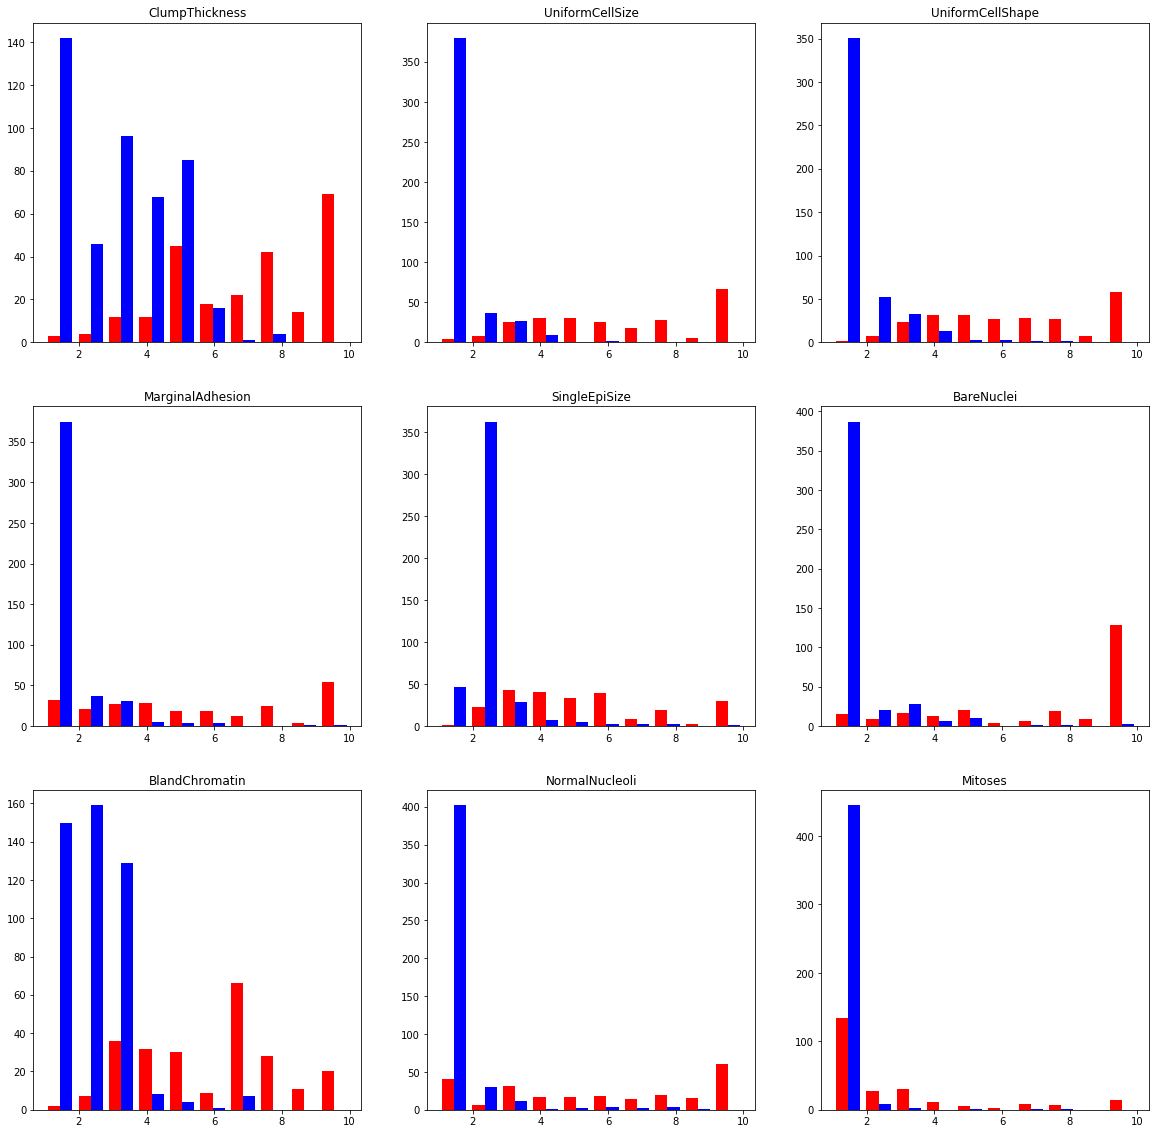

In [10]:
index = np.arange(1, 10)
fig = plt.figure(figsize=(20, 20))

for attribute, i in zip(attributes, index):
    ax = plt.subplot(3, 3, i)
    plt.hist([malignant[attribute], benign[attribute]], color=['r', 'b'])
    ax.set_title(attribute)

We plot the ratings distributions of malignant versus benign tumors to find relationships between the two types of tumors in the attributes. For all attributes, it appears lower ratings suggest benignity while higher ratings suggest the opposite. However for all attributes except Clump Thickness and Bland Chromatin, the majority of the benign distribution is contained in one integer rating. In the context of classification, a benign tumor generally must have a low rating but a malignant tumor may have any.

# Creating and Training a Model

We will test the following classification algorithms to see which models the data best:
- K Nearest Neighbors
- Support Vector Machines
- Logistic Regression
- Random Forests


In [11]:
X = df.iloc[:, :9]
y = df.iloc[:, 9]

In [17]:
KNN = KNeighborsClassifier()
SVM = SVC()
LogReg = LogisticRegression()
RF = RandomForestClassifier()

estimators = [KNN, SVM, LogReg, RF]

for estimator in estimators:
    scores = cross_val_score(estimator, X, y, cv=5)
    print(np.mean(scores), scores)
    

0.9643356439468486 [0.92907801 0.94285714 0.98571429 0.98561151 0.97841727]
0.947233313653029 [0.90070922 0.9        0.97142857 0.98561151 0.97841727]
0.9615090420065163 [0.91489362 0.94285714 0.97857143 0.98561151 0.98561151]
0.9529882719963847 [0.87943262 0.94285714 0.97142857 0.97841727 0.99280576]


C:\Users\Luke Nguyen\Documents\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Luke Nguyen\Documents\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Luke Nguyen\Documents\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Luke Nguyen\Documents\Ana

Accuracy is not a good metric because the dataset is skewed, i.e. it has more benign that malignant samples.

C:\Users\Luke Nguyen\Documents\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Luke Nguyen\Documents\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Luke Nguyen\Documents\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Luke Nguyen\Documents\Ana

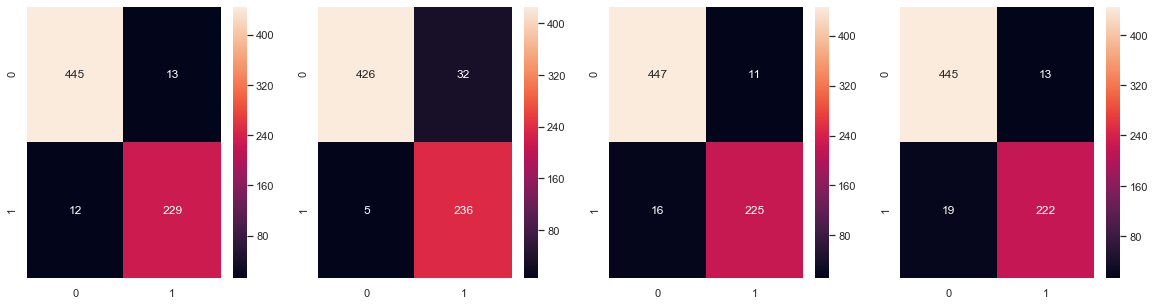

In [15]:
sns.set(rc={'figure.figsize':(20, 5)})
fig, axes = plt.subplots(1, 4)

for estimator, i in zip(estimators, np.arange(4)):
    y_pred_cv = cross_val_predict(estimator, X, y, cv=5)
    cm = confusion_matrix(y, y_pred_cv)
    sns.heatmap(cm, annot=True, ax=axes[i], fmt='.0f')    

The confusion matrices suggest all of the classifiers are similarly effective, with the Support Vector Classifier being the worse. We find the F1 scores and plot the Reciever Operating Characteristic Curve to corroborate this.